## 畳み込みニューラルネットワーク(CNN)
* これまで見てきたニューラルネットワークは全結合と呼び、Affineレイヤという名前で実装した。
* CNNでは新たにConvolutionレイヤとPoolingレイヤが加わる。（最後の出力層では同じようにAffineレイヤとSoftmaxの組み合わせが使用される）

### 全結合の問題点
* データの形状が無視されてしまうこと
* 画像データは縦・横・チャンネルの３次元ののデータがメイン
* 全結合ではこれらを１次元に変換する必要がある。

### CNN
* 畳み込み層の入出力データを**特徴マップ**と呼ぶ。
* 畳み込み層では画像処理で言うフィルター演算に相当する。

#### 流れ
* 入力データとフィルター（重み）を掛け算して、バイアスを足す。

### パディング
* 畳み込み層の処理を行う前に入力データの周囲に固定データを埋める(0や１)（パディング）
* 出力サイズを調整するために実行

### ストライド
* フィルターを適用する位置の間隔を**ストライド**という。
* これまで見てきた例は全てストライドが１であった。

###### ストライドが２の畳み込み演算の場合
* 入力サイズを(H, W),フィルターサイズを(FH, FW)、出力サイズを(OH, OW), パディングをP、 ストライドをSとする

$$OH=\frac{H+2P-FH}{S}+1$$
$$OW=\frac{W+2P-FW}{S}+1$$

### 三次元の畳み込み演算の場合
* 入力データとフィルターのチャンネル数は同じ値にする。
* ３次元データを多次元配列とする際には(channel, height, width)とする。

$$(C, H, W) \cdot (C, FH, FW) \rightarrow (1, OH, OW)$$

* 複数のフィルターがある場合

$$(C, H, W) \cdot (FN, C, FH, FW) \rightarrow (FN, OH, OW)$$

* バイアス項の追加

$$(C, H, W) \cdot (FN, C, FH, FW) \rightarrow (FN, OH, OW) + (FN, 1, 1) \rightarrow (FN, OH, OW)$$

### バッチ処理
* ４次元データとして格納：（batch_num, channel, height, width)
* Nをバッチ数とする。

$$(N, C, H, W) \cdot (FN, C, FH, FW) \rightarrow (N, FN, OH, OW) + (FN, 1, 1) \rightarrow (N, FN, OH, OW)$$

### プーリング層
* プーリングは、縦横方向の空間を小さくする演算

#### 種類
* Maxプーリング(Main)
* Averageプーリング

#### 特徴
* 学習するパラメータが少ない（最大値を取るだけ、平均値を取るだけ）
* チャンネル数は変化しない
* 微妙な位置変化に対してロバスト

### Convolution / Poolingレイヤの実装
* numpyではfor文を使用すると処理が遅くなってしまう。
* im2colと呼ばれる関数を使用する。(image to column)

In [2]:
import numpy as np
import os
os.chdir("/work/basic_deeplearning/deep-learning-from-scratch-master")

In [3]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [4]:
print(x[0].shape)
print(x[1].shape)
print(x[0, 0])#一つのデータの１チャネルの空間データにアクセス

(1, 28, 28)
(1, 28, 28)
[[0.41789691 0.78613644 0.21713459 0.58271176 0.31339786 0.30392718
  0.85063223 0.00509356 0.26159285 0.81172974 0.82282317 0.52824842
  0.56934472 0.81134957 0.16324885 0.85894155 0.08962523 0.88774151
  0.33871645 0.26947894 0.62483164 0.29602698 0.95362955 0.32830586
  0.47153896 0.85221239 0.95806938 0.11185789]
 [0.31781176 0.21241227 0.9952658  0.35308141 0.51863665 0.01750374
  0.79571175 0.73840509 0.65455736 0.01325615 0.87800218 0.49992347
  0.1319373  0.09283927 0.85797558 0.75032402 0.16313046 0.01603852
  0.63932669 0.68832789 0.30713159 0.7173216  0.87589726 0.5614329
  0.643289   0.26262472 0.96488805 0.24850248]
 [0.21830115 0.82965643 0.08409312 0.020065   0.01942593 0.04898225
  0.6630262  0.37463019 0.73058484 0.75140831 0.84450199 0.38232407
  0.88634952 0.20687717 0.60822325 0.03912718 0.68438192 0.22692198
  0.28983584 0.47773773 0.64506481 0.77622828 0.49879048 0.48273953
  0.13390176 0.75283613 0.91867461 0.43382678]
 [0.79751956 0.26902

In [5]:
from common.util import im2col
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [10]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W #重み
        self.b = b #バイアス
        self.stride = stride #ストライド
        self.pad = pad #パディング
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape #フィルターをshpaeを定義
        N, C, H, W = x.shape #入力データのshapeの定義
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride) #OH(出力サイズのxを求める)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride) #OW(出力サイズのyを求める)
        
        '''im2col
        
            input_data
            filter_height
            filter_width
            stride
            pad
            
        '''
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

In [11]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pool_h - FH) / self.stride) #OH(出力サイズのxを求める)
        out_w = int(1 + (W + 2*self.pool_w - FW) / self.stride) #OW(出力サイズのyを求める)       
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

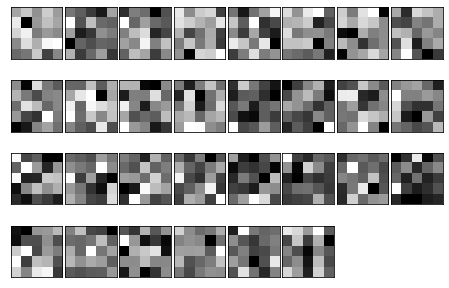

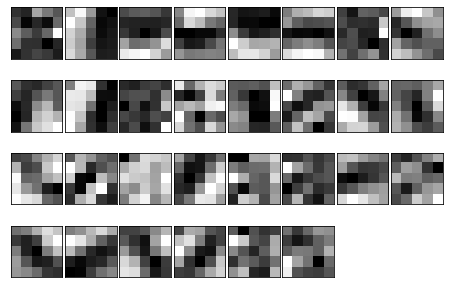

In [17]:
os.chdir("/work/basic_deeplearning/deep-learning-from-scratch-master/ch07")
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

### 代表的なCNN
* LeNet
* AlexNet